In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, RNN, LSTMCell, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def load_data(dataset_path, img_size=(256, 256)):
    """
    Loads precomputed mel-spectrogram images and extracts labels from folder names.
    Resizes images to 256x256 for higher resolution.
    """
    X = []
    y = []
    class_names = sorted(os.listdir(dataset_path))  # Get emotion categories
    
    for label in class_names:
        class_path = os.path.join(dataset_path, label)
        if not os.path.isdir(class_path):
            continue
        
        files = glob.glob(os.path.join(class_path, '*.png'))
        print(f"Found {len(files)} images for class '{label}'.")
        
        for file in files:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
            img = cv2.resize(img, img_size)  # Resize to higher resolution
            X.append(img)
            y.append(label)
    
    X = np.array(X, dtype=np.float32) / 255.0  # Normalize pixel values
    y = np.array(y)
    return X, y, class_names


In [3]:


def augment_data(X, y, augmentation_factor=0.3):
    """Apply simple data augmentation to improve model generalization"""
    aug_X = []
    aug_y = []
    
    for i in range(len(X)):
        # Original sample
        aug_X.append(X[i])
        aug_y.append(y[i])
        
        # Apply time stretching (horizontal scaling)
        if np.random.random() < augmentation_factor:
            stretched = cv2.resize(X[i], (int(X[i].shape[1] * 1.1), X[i].shape[0]))
            stretched = cv2.resize(stretched, (X[i].shape[1], X[i].shape[0]))
            aug_X.append(stretched)
            aug_y.append(y[i])
        
        # Apply frequency masking (random horizontal lines masked)
        if np.random.random() < augmentation_factor:
            masked = X[i].copy()
            num_masks = np.random.randint(1, 5)  # More masks for larger image
            for _ in range(num_masks):
                freq_width = np.random.randint(8, 25)  # Wider masks for larger image
                freq_start = np.random.randint(0, X[i].shape[0] - freq_width)
                masked[freq_start:freq_start+freq_width, :] = 0
            aug_X.append(masked)
            aug_y.append(y[i])
        
        # Add pitch shift simulation (vertical shift)
        if np.random.random() < augmentation_factor:
            shift = X[i].copy()
            shift_amount = np.random.randint(-15, 16)
            if shift_amount > 0:
                shift = np.pad(shift, ((0, 0), (shift_amount, 0)), mode='constant')[:, :-shift_amount] if shift_amount > 0 else shift
            else:
                shift = np.pad(shift, ((0, 0), (0, -shift_amount)), mode='constant')[:, -shift_amount:] if shift_amount < 0 else shift
            aug_X.append(shift)
            aug_y.append(y[i])
    
    return np.array(aug_X), np.array(aug_y)


In [4]:
def preprocess_labels(y):
    """Encodes string labels into numerical one-hot vectors."""
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_onehot = to_categorical(y_encoded)
    return y_onehot, le


In [5]:
def build_hybrid_model_256(input_shape, num_classes):
    """
    Builds a hybrid CNN-LSTM model for 256x256 inputs.
    Adjusted architecture to handle larger input dimensions.
    """
    model = Sequential()
    
    # CNN layers to extract spatial features
    model.add(Reshape((input_shape[0], input_shape[1], 1), input_shape=input_shape))
    
    # First conv block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))  # Output: 128x128x32
    
    # Second conv block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))  # Output: 64x64x64
    
    # Third conv block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))  # Output: 32x32x128
    
    # Fourth conv block - added for larger input size
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))  # Output: 16x16x256
    
    # Reshape for LSTM - treat rows as time steps
    # After 4 MaxPooling layers, we have 16x16x256, reshape to 16 timesteps with 16*256 features
    model.add(Reshape((16, 16*256)))
    
    # LSTM layers for temporal features
    model.add(RNN(LSTMCell(384), return_sequences=True))  # Increased units for larger input
    model.add(Dropout(0.4))  # Slightly higher dropout for more regularization
    model.add(RNN(LSTMCell(192)))  # Increased units
    model.add(Dropout(0.4))
    
    # Classification layers
    model.add(Dense(192, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(96, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model


In [6]:


def main():
    # Configuration parameters
    dataset_path = 'RAVDESS_mel_spectrograms'  # Update with your dataset path
    img_size = (256, 256)  # Increased from 192x192 to 256x256
    test_size = 0.15
    val_size = 0.15
    batch_size = 8  # Reduced batch size to account for larger model
    max_epochs = 500
    
    # Load and preprocess data with larger image size
    X, y, class_names = load_data(dataset_path, img_size)
    print(f"Original dataset: {X.shape[0]} samples")
    print(f"Image shape: {X[0].shape}")
    
    # Apply data augmentation
    X_aug, y_aug = augment_data(X, y)
    print(f"Augmented dataset: {X_aug.shape[0]} samples")
    
    # Encode labels
    y_onehot, le = preprocess_labels(y_aug)
    
    # Create train, validation, and test sets
    # First split off the test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_aug, y_onehot, test_size=test_size, random_state=42, 
        stratify=np.argmax(y_onehot, axis=1)
    )
    
    # Then split the remaining data into train and validation
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, random_state=42,
        stratify=np.argmax(y_temp, axis=1)
    )
    
    print(f"Train: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")
    
    # Memory usage management
    tf.keras.backend.clear_session()
    
    # Build and compile the model for 256x256 inputs
    input_shape = X_train.shape[1:]  # (256, 256)
    num_classes = y_onehot.shape[1]
    model = build_hybrid_model_256(input_shape, num_classes)
    
    # Memory usage estimate
    param_count = model.count_params()
    print(f"Model has {param_count:,} parameters")
    
    # Create optimizer with learning rate
    initial_lr = 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    # Print model summary
    model.summary()
    
    # Callbacks for training
    checkpoint = ModelCheckpoint(
        'best_emotion_model_256x256.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
    
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
    
    # Train the model
    try:
        history = model.fit(
            X_train, y_train,
            epochs=max_epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=[early_stop, checkpoint, reduce_lr],
            verbose=1
        )
        
        # Evaluate on the test set
        test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test)
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Test Precision: {test_precision:.4f}")
        print(f"Test Recall: {test_recall:.4f}")
        
        # Generate predictions and evaluate in detail
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(
            y_true_classes, 
            y_pred_classes, 
            target_names=[le.inverse_transform([i])[0] for i in range(num_classes)]
        ))
        
        # Plot training history
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='lower right')
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper right')
        
        plt.tight_layout()
        plt.savefig('training_history_256x256.png')
        plt.show()
        
    except tf.errors.ResourceExhaustedError:
        print("Memory error encountered. Try reducing batch size or model complexity.")
        
    except Exception as e:
        print(f"Error during training: {e}")
        


Found 192 images for class 'angry'.
Found 192 images for class 'calm'.
Found 192 images for class 'disgust'.
Found 192 images for class 'fearful'.
Found 192 images for class 'happy'.
Found 96 images for class 'neutral'.
Found 192 images for class 'sad'.
Found 192 images for class 'surprised'.
Original dataset: 1440 samples
Image shape: (256, 256)
Augmented dataset: 2682 samples
Train: 1876, Validation: 403, Test: 403
Model has 7,967,880 parameters
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   


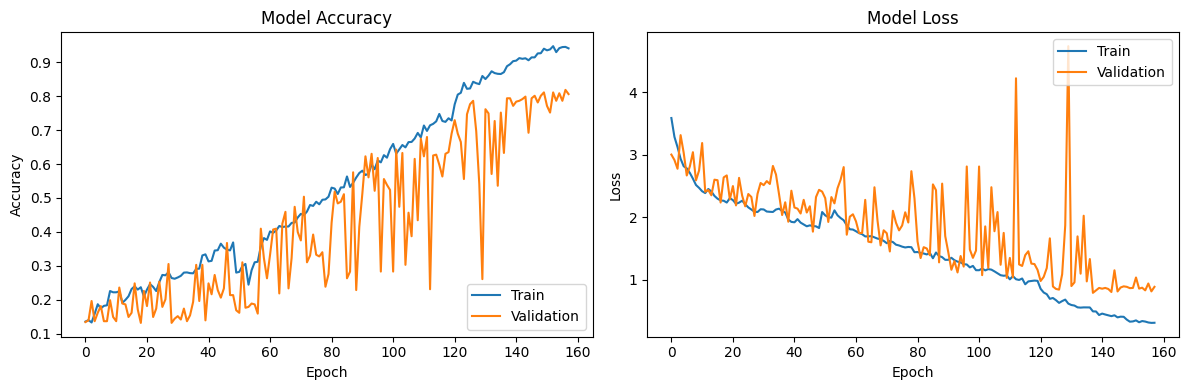

In [7]:


if __name__ == '__main__':
    main()